In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from hazm import *
from PersianStemmer import *
from gensim.models.doc2vec import Doc2Vec
%matplotlib inline
%config IPCompleter.greedy=True

In [69]:
def normalizetext(textstring):
    normalize = Normalizer()
    # lemmatizer = Lemmatizer()
    return ' '.join([word for word in normalize.normalize(textstring).split() if word not in (stopwords_list())])

In [70]:
def create_docmodel(x, y, feature_count):
    docs = []
    dfs = []
    features_vectors = pd.DataFrame()
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
    for i, text in enumerate(x):
        words = text.lower().split()
        tags = [i]
        docs.append(analyzedDocument(words, tags))
    model = Doc2Vec(docs, size=feature_count, window=300, min_count=1, workers=4)
    for i in range(model.docvecs.__len__()):
        dfs.append(model.docvecs[i].transpose())

    features_vectors = pd.DataFrame(dfs)
    features_vectors['label'] = y
    return features_vectors, model

In [71]:
df = pd.read_csv('workorder.csv',delimiter=',',encoding='utf-8')
df.head()

,v1,v2
0,NOTCONS,اختصاص پروفايل
1,NOTCONS,نصب OverHual
2,CONS,نياز به يك عدد ماوس
3,NOTCONS,نصب ويندوز
4,CONS,نياز به تامين ست باطري كارت ساعت (9 تايي)


In [72]:
df['v2'] = df['v2'].apply(normalizetext)
df.head()

,v1,v2
0,NOTCONS,اختصاص پروفایل
1,NOTCONS,نصب OverHual
2,CONS,عدد ماوس
3,NOTCONS,نصب ویندوز
4,CONS,تامین ست باطری کارت ساعت (۹ تایی)


In [43]:
# df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

Text(0.5, 1.0, 'Number of ham and spam messages')

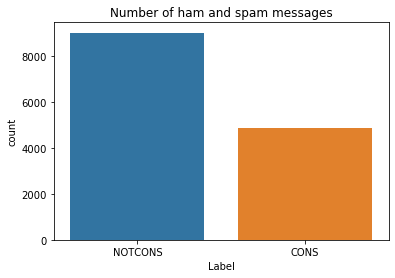

In [44]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [45]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [66]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [75]:
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [74]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(512,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [55]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          100000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
FC1 (Dense)                  (None, 512)               66048     
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 513 

In [56]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

d:\shared\python37_64\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9410 samples, validate on 2353 samples
Epoch 1/10
9410/9410 [==============================] - 6s 665us/step - loss: 0.2583 - accuracy: 0.8885 - val_loss: 0.1410 - val_accuracy: 0.9541
Epoch 2/10
9410/9410 [==============================] - 6s 609us/step - loss: 0.1292 - accuracy: 0.9574 - val_loss: 0.1278 - val_accuracy: 0.9571
Epoch 3/10
9410/9410 [==============================] - 6s 610us/step - loss: 0.1560 - accuracy: 0.9523 - val_loss: 0.1251 - val_accuracy: 0.9592
Epoch 4/10
9410/9410 [==============================] - 6s 615us/step - loss: 0.1135 - accuracy: 0.9625 - val_loss: 0.1317 - val_accuracy: 0.9571


In [57]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [58]:
accr = model.evaluate(test_sequences_matrix,Y_test)


2076/2076 [==============================] - 1s 462us/step


In [59]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]*100))

Test set
  Loss: 0.130
  Accuracy: 95.376


In [60]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_sequences_matrix).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

In [61]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

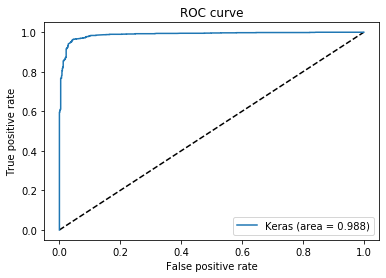

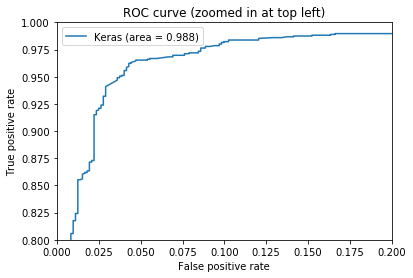

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()